# Test different metrics of surprise for framework paper

### set a measure of potential for inputs
 - for each road segment that is blocked calculate the potential as the capacity (lanes * speed)

In [1]:
from concurrent.futures import ThreadPoolExecutor
import sqlite3
import pickle
import pandas as pd
import json
import xml.etree.ElementTree as ET

In [2]:
def read_fleet_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()   
    print("Length of rows: ", len(rows)) 
    for row in rows:
        ID = row[0]
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inIDS, output_90, output_100, odist]

        d = tmpDat
        scen = {}
            
        #try:
        #    root = d[2].getroot()
        #except:
        #    print('error')
        #    root = []
        #    continue
        scenID = d[0]
        #print(root.tag)
        #for child in root:    
        #    ### find the segment ID
        #    segmentID = child.find('ID').text
        #    speed = float(child.find('Freeflow_Speed').text)
        #    lanes = float(child.find('Number_of_Lanes').text)
        #    blocked = False
        #    if segmentID in link_ids:
        #        scen[segmentID] = speed
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

def read_ladris_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()    
    for row in rows:
        ID = row[0]
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inXML, output_90, output_100, odist]

        d = tmpDat
        scen = {}

        scenID = d[0]
        #print(root.tag)
        #for child in d[2]:    
        #    ### find the segment ID
        #    segmentID = child['osmid']
        #    speed = float(child['speed_mph'])
        #    lanes = float(child['num_lanes'])
        #    blocked = child['is_blocked']
        #    if blocked == True:
        #        scen[segmentID] = 1
        #    #if segmentID in link_ids:
        #        #scen[segmentID] = blocked
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

In [3]:
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_roadBlocked_scenarios.db'
#dbFile = 'lhc_samples/fleet_scenarios_conv1.db'
dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv1.db'
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv2.db'
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv2.db'
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/ladris_scenarios_conv2.db'
comb_scenarios = {}


In [4]:
queries = [
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 4000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 6000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 1000 offset 8000',    
]

dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv2.db'
with ThreadPoolExecutor(max_workers=6) as executor:
    ### if db file has fleet use function read_fleet_from_db else use read_ladris_from_db
    if 'fleet' in dbFile:
        for result in executor.map(read_fleet_from_db, queries):
            comb_scenarios.update(result)        
    else:
        for result in executor.map(read_ladris_from_db, queries):
            comb_scenarios.update(result)    

print(len(comb_scenarios))

Length of rows:  0
Length of rows:  0
Length of rows:  0
Length of rows:  0
Length of rows:  2000
2000


In [5]:
### join 3 sqlite database files
#dbFile1 = '/home/pfoytik/rtepm/EMA/lhc_samples/guid_blocked_ladris_scenarios.db'
#dbFile2 = '/home/pfoytik/rtepm/EMA/lhc_samples/ladris_scenarios_conv1.db'
#dbFile3 = '/home/pfoytik/rtepm/EMA/lhc_samples/ladris_scenarios_conv2.db'

#dbFile1 = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_roadBlocked_scenarios.db'
dbFile2 = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv1.db'
dbFile3 = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv2.db'
dbFiles = [dbFile2, dbFile3]
comb_scenarios = {}
scenCount = 0
for dbFile in dbFiles:
    with ThreadPoolExecutor(max_workers=6) as executor:
        ### if db file has fleet use function read_fleet_from_db else use read_ladris_from_db
        if 'fleet' in dbFile:
            for result in executor.map(read_fleet_from_db, queries):
                comb_scenarios.update(result)        
        else:
            for result in executor.map(read_ladris_from_db, queries):
                for key, value in result.items():
                    if key in comb_scenarios:
                        new_key = scenCount + int(key)
                        scenCount += 1
                        comb_scenarios[new_key] = value
                    else:
                        comb_scenarios[key] = value 
print(len(comb_scenarios))

Length of rows:  292
Length of rows:  0
Length of rows:  0
Length of rows:  0
Length of rows:  2000
Length of rows:  0
Length of rows:  0
Length of rows:  0
Length of rows:  0
Length of rows:  2000
3896


# Get Ladris Roads
- Potential is measured as Lanes * Speed * Length

In [6]:
roadFile = '../lhc_samples/data/ladris/C27F9DE4CE6780696685FB4A4E31E242_orig'
with open(roadFile, 'r') as f:
    data = json.load(f)

ladris_latlong_dict = {}
ladris_potential_dict = {}
modified_dict = {}

for i in data:
    #print(i)
    ladris_latlong_dict[i['AC91D0B60F78BEFB85DE39CD9C3D2623']] = i['geometry']
    lanes = i['num_lanes']
    speed = i['speed_mph']
    ### convert speed to m/s
    speed = speed * 0.44704
    length = i['length_meters']
    ladris_potential_dict[i['AC91D0B60F78BEFB85DE39CD9C3D2623']] = lanes * speed * length

In [7]:
ladris_latlong_dict[328123]

[[-121.1880419, 39.2519689],
 [-121.1879476, 39.2520865],
 [-121.1878389, 39.2522869],
 [-121.187756, 39.252606],
 [-121.1878234, 39.2528889],
 [-121.1878816, 39.2531086],
 [-121.1879835, 39.2533059],
 [-121.188129, 39.2534355],
 [-121.1882818, 39.2535031],
 [-121.1885147, 39.2535482],
 [-121.1887549, 39.2535257],
 [-121.1890532, 39.2534242],
 [-121.189257, 39.2532157],
 [-121.1893226, 39.2529208],
 [-121.1895626, 39.2526606]]

# Get Fleet Roads

In [8]:
### read segment id's from ../lhc_samples/data/fleet/segments.xml
tree = ET.parse('../lhc_samples/data/fleet/segments.xml')
root = tree.getroot()

fleet_segment_dict = {}
fleet_potential_dict = {}
for child in root:
    fleet_segment_dict[child.find('ID').text] = child.find('Link_ID').text
    lanes = int(child.find('Number_of_Lanes').text)
    speed = int(child.find('Freeflow_Speed').text)
    fleet_potential_dict[child.find('ID').text] = lanes * speed

### read ../lhcsamples/data/fleet/links.xml
tree = ET.parse('../lhc_samples/data/fleet/links.xml')
root = tree.getroot()

fleet_link_dict = {}
fleet_name_dict = {}
for child in root:
    fleet_link_dict[child.find('ID').text] = [child.find('ANode').text, child.find('BNode').text]    
    fleet_name_dict[child.find('ID').text] = child.find('Name').text

### read ../lhcsamples/data/fleet/nodes.xml and get lat long for BNode of each fleet_link_dict
tree = ET.parse('../lhc_samples/data/fleet/nodes.xml')
root = tree.getroot()

fleet_node_dict = {}
for child in root:
    fleet_node_dict[child.find('ID').text] = [child.find('Latitude').text, child.find('Longitude').text]

fleet_lat_long_dict = {}
### for each segment in fleet_segment_dict, get the link_id, from fleet_link_dict get the BNode, from fleet_node_dict get the lat long
for segment in fleet_segment_dict:
    link_id = fleet_segment_dict[segment]
    anode = fleet_link_dict[link_id][0]
    bnode = fleet_link_dict[link_id][1]
    lat_long = [fleet_node_dict[anode], fleet_node_dict[bnode]]
    fleet_lat_long_dict[int(segment)] = [[float(lat_long[0][1]), float(lat_long[0][0])],[float(lat_long[1][1]), float(lat_long[1][0])]]

In [9]:
df_results = pd.DataFrame([x[1] for x in comb_scenarios.values()])

dataDict = {}
for k in comb_scenarios.keys():
    for link in comb_scenarios[k][0]:        
        if link in dataDict.keys():
            pass
        else:
            #if link in link_ids:
            dataDict[link] = []   

for k in comb_scenarios.keys():
    for i in dataDict.keys():
        if i in comb_scenarios[k][0]:
            #if link in link_ids:
            dataDict[i].append(1)
        else:
            #if link in link_ids:
            dataDict[i].append(0) 

df = pd.DataFrame(dataDict)



In [10]:
if 'ladris' in dbFile:
    df_results['minutes'] = df_results[0] * 60
    df_results['hours'] = df_results[0]
else:
    ### create a new column for the df_results called minutes that is equal to df_results[0] / 60
    df_results['minutes'] = df_results[0] / 60
    ### create a new column for df_results called hours that is equal to df_results[0] / 3600
    df_results['hours'] = df_results[0] / 3600

df_results.describe()

,0,minutes,hours
count,3896.000000,3896.000000,3896.000000
mean,12577.284394,209.621407,3.493690
std,3661.927762,61.032129,1.017202
min,9600.000000,160.000000,2.666667
25%,9600.000000,160.000000,2.666667
50%,12900.000000,215.000000,3.583333
75%,13200.000000,220.000000,3.666667
max,30000.000000,500.000000,8.333333


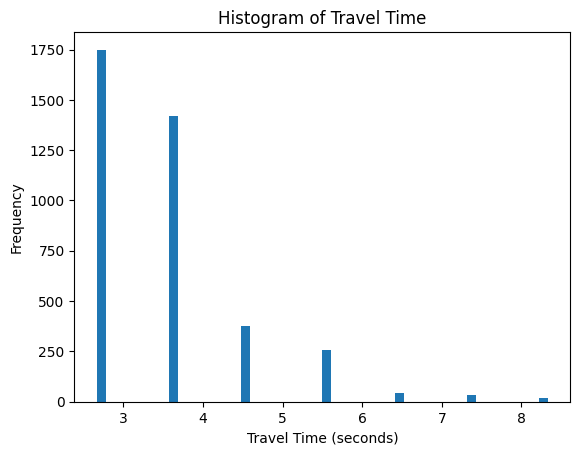

In [11]:
### Plot histogram of df_results
import matplotlib.pyplot as plt
plt.hist(df_results['hours'], bins=50)
plt.xlabel('Travel Time (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Travel Time')
plt.show()

In [12]:
df_results['hours']

0       2.666667
1       4.583333
2       3.666667
3       3.666667
4       3.583333
          ...   
3891    3.583333
3892    2.666667
3893    3.666667
3894    3.666667
3895    3.583333
Name: hours, Length: 3896, dtype: float64

In [13]:

### get indexs of df_results for df_results['hours'] >= 6.5
idx = df_results[df_results['hours'] >= 4].index
### get indexs of df_results for df_results['hours'] < 6.5
idx2 = df_results[df_results['hours'] < 4].index

### describe df_results for the indexs of idx
df_results.loc[idx].describe()

,0,minutes,hours
count,727.000000,727.000000,727.000000
mean,18884.319120,314.738652,5.245644
std,3222.916659,53.715278,0.895255
min,16200.000000,270.000000,4.500000
25%,16500.000000,275.000000,4.583333
50%,16500.000000,275.000000,4.583333
75%,19800.000000,330.000000,5.500000
max,30000.000000,500.000000,8.333333


In [14]:
experiments = df
lowExperiments = experiments.loc[idx2]
highExperiments = experiments.loc[idx]
### Create outcomes as an array of df_results
outcomes = list(df_results['hours'].values)
lowOutcomes = list(df_results.loc[idx2]['hours'].values)
highOutcomes = list(df_results.loc[idx]['hours'].values)

In [15]:
### describe highOutcomes
pd.Series(highOutcomes).describe()

count    727.000000
mean       5.245644
std        0.895255
min        4.500000
25%        4.583333
50%        4.583333
75%        5.500000
max        8.333333
dtype: float64

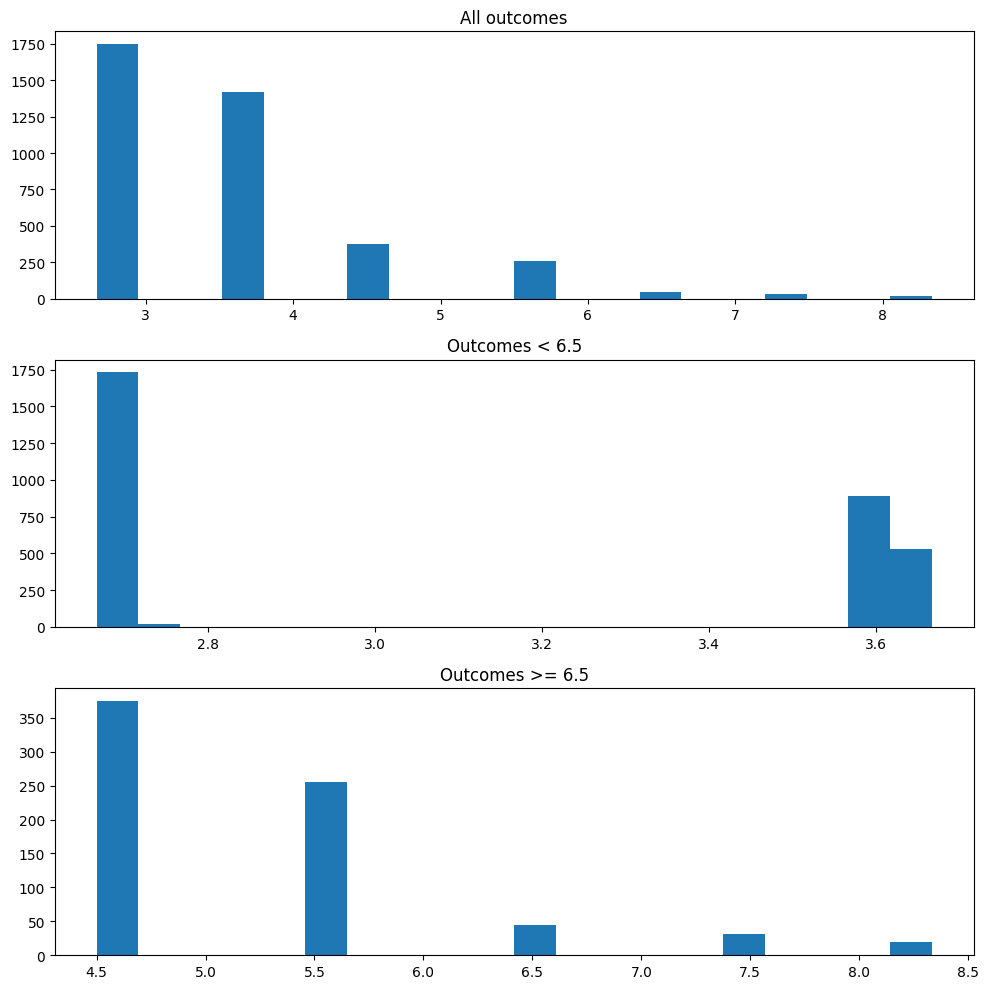

In [16]:
import matplotlib.pyplot as plt

### create three subplots of the outcomes
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].hist(outcomes, bins=20)
ax[0].set_title('All outcomes')
ax[1].hist(lowOutcomes, bins=20)
ax[1].set_title('Outcomes < 6.5')
ax[2].hist(highOutcomes, bins=20)
ax[2].set_title('Outcomes >= 6.5')
plt.tight_layout()
plt.show()


# Defined High critical segments for LAdris

In [17]:
### ladris_hc is the high critical segments identified from clustering methods
ladris_hc = [334722, 329091, 334420, 329644, 330512, 330221,
       341386, 336153, 338651, 329174, 330184, 329821,
       329502, 344238, 332329, 335525, 341295, 334250,
       332253, 342952, 335197, 333480]

for i in ladris_hc:
    if ladris_potential_dict[i] < 68:
        print(i, ladris_potential_dict[i])


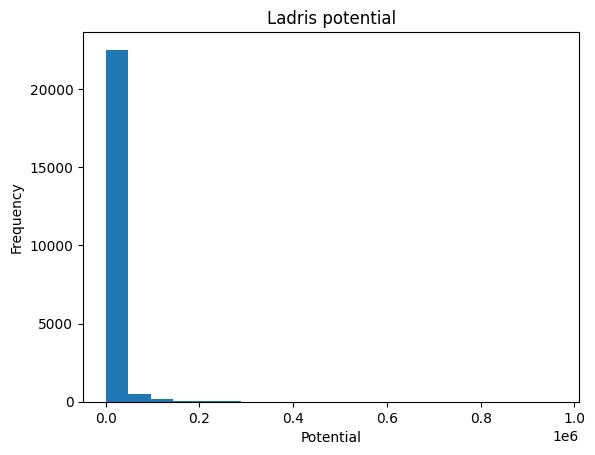

In [18]:
### print histogram of ladris_potential_dict
plt.hist(list(ladris_potential_dict.values()), bins=20)
plt.title('Ladris potential')
plt.xlabel('Potential')
plt.ylabel('Frequency')
plt.show()

In [19]:
### print df where columns are in ladris_hc
df.loc[:, ladris_hc].describe()

KeyError: "None of [Index([334722, 329091, 334420, 329644, 330512, 330221, 341386, 336153, 338651,\n       329174, 330184, 329821, 329502, 344238, 332329, 335525, 341295, 334250,\n       332253, 342952, 335197, 333480],\n      dtype='int64')] are in the [columns]"

In [ ]:
### get all rows of df where columns defined in ladris_hc are 1
lad_hc_filtered_df = df.loc[:,ladris_hc]
lad_hc_filtered_df

KeyError: "None of [Index([334722, 329091, 334420, 329644, 330512, 330221, 341386, 336153, 338651,\n       329174, 330184, 329821, 329502, 344238, 332329, 335525, 341295, 334250,\n       332253, 342952, 335197, 333480],\n      dtype='int64')] are in the [columns]"

In [ ]:
### how many segments have potential less than 50
count = 0
for i in ladris_potential_dict:
    if ladris_potential_dict[i] < 50:
        count += 1
### print the total number of segments with potential less than 50 and the total number of segments
print('Total number of segments with potential less than 50: ', count)
### print the total number of segments
print('Total number of segments: ', len(ladris_potential_dict))

Total number of segments with potential less than 50:  17
Total number of segments:  23248


In [ ]:
### get a list of all the segment keys in ladris_potential_dict that have values less than 50
low_potential_segments = []
for i in ladris_potential_dict:
    if ladris_potential_dict[i] < 400:
        low_potential_segments.append(i)
### print the number of segments in low_potential_segments
print('Number of segments with potential less than 25: ', len(low_potential_segments))

Number of segments with potential less than 25:  412


In [ ]:
lad_hc_filtered_df.columns

NameError: name 'lad_hc_filtered_df' is not defined

In [ ]:
### how many segments in low_potential_segments are in lad_hc_filtered_df
count = 0
lp_evac = []
for i in low_potential_segments:
    if i in lad_hc_filtered_df.columns:
        count += 1
        if i not in lp_evac:
            lp_evac.append(i)
### print the number of segments in low_potential_segments that are in df.columns
print('Number of segments in low_potential_segments that are in df.columns: ', count)

NameError: name 'lad_hc_filtered_df' is not defined

In [20]:
### get rows of df[lp_evac] where any of the columns are 1
lp_evac_df = df.loc[:, lp_evac]

NameError: name 'lp_evac' is not defined

In [21]:
lp_evac_df

NameError: name 'lp_evac_df' is not defined

In [22]:
### get all the rows of df where any of the columns in lp_evac are 1
#lp_evac_df = df[lp_evac]
### get the index of the lp_evac_df where any of the columns are 1
lp_evac_idx = lp_evac_df[lp_evac_df.any(axis=1)].index
### print the number of rows in lp_evac_df
print('Number of rows in lp_evac_df: ', len(lp_evac_df))
### print the number of rows in df where any of the columns in lp_evac are 1
print('Number of rows in df where any of the columns in lp_evac are 1: ', len(df[df.any(axis=1)]))
### print the number of rows in df where any of the columns in lp_evac are 1
print('Number of rows in df where any of the columns in lp_evac are 1: ', len(df[lp_evac_df.any(axis=1)]))


NameError: name 'lp_evac_df' is not defined

In [23]:
lp_evac_idx

NameError: name 'lp_evac_idx' is not defined

In [24]:
### get the index of df_results where values are greater than 4
idx = df_results[df_results['hours'] > 4].index
hc_df = df.loc[idx]

### get the row index of hc_df where any of the columns in lp_evac are 1
hc_evac_idx = hc_df[hc_df.any(axis=1)].index
print(len(hc_evac_idx))


726


In [25]:
hc_evac_idx

Index([   1,    5,    7,    8,   10,   12,   15,   16,   23,   26,
       ...
       3733, 3735, 3763, 3780, 3816, 3826, 3841, 3846, 3850, 3862],
      dtype='int64', length=726)

# Index Definitions
- lp_evacu_idx = index of rows that are low potential
- hc_evac_idx = index of rows that are high critical

In [26]:
### plot histogram of df_results.loc[hc_evac_idx]['hours'] and df_results.loc[lp_evac_idx]['hours']
plt.hist(df_results.loc[lp_evac_idx]['hours'], bins=20)
plt.hist(df_results.loc[hc_evac_idx]['hours'], bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of High Outcomes')
plt.show()

NameError: name 'lp_evac_idx' is not defined

In [27]:
### get the index values of df_results.loc[lp_evac_idx]['hours] that are greater than 4
mask = df_results.loc[lp_evac_idx]['hours'] > 4
### get the index of df_results where df_results['hours'] > 4
lp_hc_ladris_results_idx = df_results[df_results['hours'] > 4].index



NameError: name 'lp_evac_idx' is not defined

In [28]:
len(lp_hc_ladris_results_idx)

NameError: name 'lp_hc_ladris_results_idx' is not defined

In [29]:
### plot histogram of df_results.loc[lp_hc_ladris_results_idx]['hours']
plt.hist(df_results.loc[lp_hc_ladris_results_idx]['hours'], bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of High Outcomes and low potential')
plt.show()

NameError: name 'lp_hc_ladris_results_idx' is not defined

In [30]:
### get the df_results where the index is in lp_hc_ladris_results_idx

In [31]:
### Plot a histogram of the potential of the segments in lp_evac
plt.hist([ladris_potential_dict[i] for i in lp_evac], bins=20)
plt.xlabel('Potential')
plt.ylabel('Frequency')
plt.title('Histogram of Low Potential Segments')
plt.show()

NameError: name 'lp_evac' is not defined

In [32]:
intersect_pot_crit = []
### print the potential of the segments in lp_evac that are less than 80
for i in lp_evac:
    if ladris_potential_dict[i] < 60:
        print(i, ladris_potential_dict[i])
        intersect_pot_crit.append(i)

NameError: name 'lp_evac' is not defined

In [33]:
### get rows of lp_evac_df where any of the columns are in intersect_pot_crit are 1 and are in lp_hc_ladris_results_idx

lp80_hc4_evac_df = lp_evac_df.loc[lp_hc_ladris_results_idx]
### get lp80_hc4_evac_df where any of the columns are in intersect_pot_crit are 1
lp80_hc4_evac_df = lp80_hc4_evac_df.loc[:, intersect_pot_crit]
### get the index of lp80_hc4_evac_df where any of the columns are 1
lp80_hc4_evac_idx = lp80_hc4_evac_df[lp80_hc4_evac_df.any(axis=1)].index

### print the number of rows in lp_evac_df
print('Number of rows in lp_evac_df: ', len(lp80_hc4_evac_df))
### print the number of rows in df where any of the columns in lp_evac are 1
print('Number of rows in df where any of the columns in lp_evac are 1: ', len(lp_evac_df[lp_evac_df.any(axis=1)]))
### print the number of rows in df where any of the columns in lp_evac are 1
print('Number of rows in df where any of the columns in lp_evac are 1: ', len(lp80_hc4_evac_df[lp80_hc4_evac_df.any(axis=1)]))


NameError: name 'lp_evac_df' is not defined

In [34]:
### lp_hc_ladris_results_idx
converged_idx = lp80_hc4_evac_df[lp80_hc4_evac_df.any(axis=1)].index
print('Number of rows in lp80_hc4_evac_df: ', len(converged_idx))
### plot histogram of df_results.loc[converged_idx]['hours']
plt.hist(df_results.loc[converged_idx]['hours'], bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of High Outcomes and low potential')
plt.show()

NameError: name 'lp80_hc4_evac_df' is not defined

# The list of segments that are associated with High critical evacuation times and are low on potential
## Ladris Critical Segments
![image.png](images/ladris_critical_segments.png)
## Ladris Critical and Low Potential (CSI)
![image.png](images/lp80_hc4.png)
## Fleet Critical Segments
![image.png](images/fleet_critical_segments.png)
## Fleet Critical and Low Potential (CSI)
![image-2.png](images/fleet_CSI_segments.png)



In [35]:
lp80_hc4_evac_df.loc[converged_idx]

NameError: name 'lp80_hc4_evac_df' is not defined

# Custom surprising critical measure
$$
Z=λ_1 × EvacuationTime − λ_2 × ScenarioPotential
$$
- Evacuation time is time 90% of population reaches destination
- Scenario Potential is the total potential measure of closed segments for that scenario

In [36]:
### create a new dataframe from df where each column is multiplied by the corresponding value in ladris_potential_dict
ladris_potential_df = df.copy()
for i in ladris_potential_dict:
    if i in ladris_potential_df.columns:
        ladris_potential_df[i] = ladris_potential_df[i] * ladris_potential_dict[i]

ladris_potential_df.head()

,10091169783,949301691,10949397063,711440306,10116952815,711443713,10946271023,10105537445,10116970483,11156823230,...,703766232,105574067,949536370,10708503028,105576314,10091169790,949283531,711443269,91170034,10710783587
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,1,0,0,0,1,...,1,1,1,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,1,1,1,...,1,0,0,1,1,1,1,1,0,0
3,1,0,1,0,1,0,1,0,1,1,...,1,1,0,1,1,1,0,0,1,0
4,0,0,1,1,1,1,1,0,1,0,...,1,1,0,0,1,1,0,0,0,0


In [37]:
### add a new column to ladris_potential_df that is the sum of all the columns
ladris_potential_df['sum'] = ladris_potential_df.sum(axis=1)

### create a new column in ladris_potential_df called 'count' that is the count of columns that are greater than 0
ladris_potential_df['count'] = (ladris_potential_df > 0).sum(axis=1)

ladris_potential_df

,10091169783,949301691,10949397063,711440306,10116952815,711443713,10946271023,10105537445,10116970483,11156823230,...,949536370,10708503028,105576314,10091169790,949283531,711443269,91170034,10710783587,sum,count
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,18,19
1,1,1,1,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,22,23
2,1,0,0,1,0,0,0,1,1,1,...,0,1,1,1,1,1,0,0,17,18
3,1,0,1,0,1,0,1,0,1,1,...,0,1,1,1,0,0,1,0,17,18
4,0,0,1,1,1,1,1,0,1,0,...,0,0,1,1,0,0,0,0,16,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3891,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,5,6
3892,1,1,0,0,0,1,0,1,1,0,...,1,0,0,0,0,0,0,0,7,8
3893,0,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,6,7
3894,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,5,6


In [38]:
lam1 = 0.5
lam2 = 1

### create x as a normalized measure of df_results['hours'] to be values between 0 and 1
normEvac = (df_results['hours'] - df_results['hours'].min()) / (df_results['hours'].max() - df_results['hours'].min())

### creaet normPot as a normalized measure of ladris_potential_df['sum'] to be values between 0 and 1
normPot = (ladris_potential_df['sum'] - ladris_potential_df['sum'].min()) / (ladris_potential_df['sum'].max() - ladris_potential_df['sum'].min())

df_results['z'] = lam1*normEvac - lam2*normPot + lam2

df_results.head()


,0,minutes,hours,z
0,9600,160.0,2.666667,0.333333
1,16500,275.0,4.583333,0.354303
2,13200,220.0,3.666667,0.458606
3,13200,220.0,3.666667,0.458606
4,12900,215.0,3.583333,0.488290


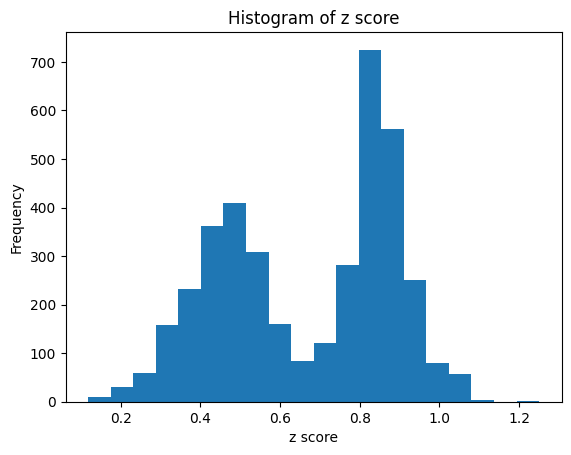

In [39]:
### Plot histogram of df_results['z']
plt.hist(df_results['z'], bins=20)
plt.xlabel('z score')
plt.ylabel('Frequency')
plt.title('Histogram of z score')
plt.show()

In [40]:
df_results['z'].describe()

count    3896.000000
mean        0.670699
std         0.217304
min         0.118464
25%         0.481481
50%         0.754902
75%         0.851852
max         1.250000
Name: z, dtype: float64

In [41]:
df.describe()

,10091169783,949301691,10949397063,711440306,10116952815,711443713,10946271023,10105537445,10116970483,11156823230,...,703766232,105574067,949536370,10708503028,105576314,10091169790,949283531,711443269,91170034,10710783587
count,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,...,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000
mean,0.500513,0.501283,0.245893,0.242556,0.243840,0.501797,0.242556,0.500000,0.500770,0.244353,...,0.246150,0.243840,0.498973,0.242813,0.244097,0.245380,0.244610,0.243070,0.243326,0.244610
std,0.500064,0.500063,0.430671,0.428684,0.429452,0.500061,0.428684,0.500064,0.500064,0.429758,...,0.430822,0.429452,0.500063,0.428838,0.429605,0.430367,0.429911,0.428992,0.429146,0.429911
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.500000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
import prim

# Perform Prim Analysis on df_results and df based on maximizing critical (hours)

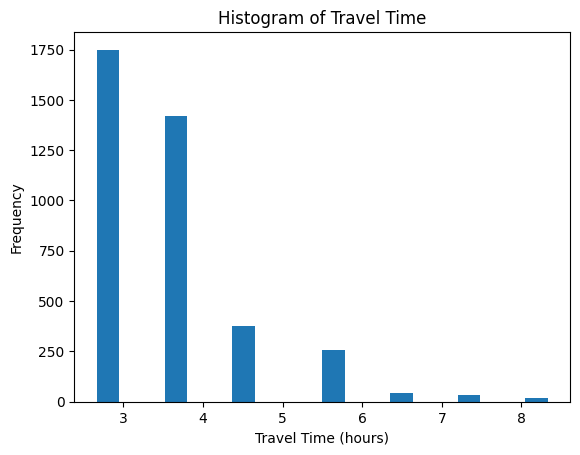

In [43]:
### plot histogram of df_results['hours']
plt.hist(df_results['hours'], bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Travel Time')
plt.show()


In [52]:
### get the index values of df_results.loc[lp_evac_idx]['hours] that are greater than 4
#mask = df_results.loc[lp_evac_idx]['hours'] > 4
### get the index of df_results where df_results['hours'] > 4
critical_fleet_results_idx = df_results[df_results['hours'] > 4].index

### describe df_results.loc[critical_fleet_results_idx]
df_results.loc[critical_fleet_results_idx].describe()

,0,minutes,hours,z
count,727.000000,727.000000,727.000000,727.000000
mean,18884.319120,314.738652,5.245644,0.631755
std,3222.916659,53.715278,0.895255,0.220564
min,16200.000000,270.000000,4.500000,0.243192
25%,16500.000000,275.000000,4.583333,0.465414
50%,16500.000000,275.000000,4.583333,0.576525
75%,19800.000000,330.000000,5.500000,0.752451
max,30000.000000,500.000000,8.333333,1.250000


In [53]:
prim_alg = prim.Prim(df.loc[critical_fleet_results_idx], df_results.loc[critical_fleet_results_idx]['hours'], threshold=5, threshold_type='>')
crit_box = prim_alg.find_all()
print(len(crit_box))

9


In [54]:
crit_box[0].limits

/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


,min,max,qp values
10946271023,0.0,0.0,NaN
10116970483,1.0,1.0,NaN
91170204,0.0,0.0,NaN
10091170129,1.0,1.0,NaN
1175163236,0.0,0.0,NaN
10116945306,1.0,1.0,NaN
91170034,0.0,0.0,NaN


# Perform Prim Analysis on df_results and df based on maximizing z


In [55]:
df_results['z'].describe()

count    3896.000000
mean        0.670699
std         0.217304
min         0.118464
25%         0.481481
50%         0.754902
75%         0.851852
max         1.250000
Name: z, dtype: float64

In [56]:
### Get the index of rows in df_results['z'] that are greater than 0.1
idx = df_results[df_results['z'] > 0.75].index
### print the rows of df where the index is in idx
#df.loc[idx].describe()
df_results.loc[idx]['z'].describe()

count    1954.000000
mean        0.865341
std         0.063306
min         0.752451
25%         0.814815
50%         0.851852
75%         0.895697
max         1.250000
Name: z, dtype: float64

In [57]:
prim_alg = prim.Prim(df.loc[idx], df_results.loc[idx]['z'], threshold=0.89, threshold_type='>')
CSI_box = prim_alg.find_all()
print(len(CSI_box))

6


In [58]:
CSI_box[1].limits

/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


,min,max,qp values
10949397063,0.0,0.0,NaN
10116970483,1.0,1.0,NaN
11156823230,0.0,0.0,NaN
10091170129,1.0,1.0,NaN
10116945306,1.0,1.0,NaN
10091169790,0.0,0.0,NaN


# Generate KML for crit_box and CSI_box IDs


In [62]:
### get list of all index values for each crit_box
crit_ids = []
for i in range(len(crit_box)):
    print(list(crit_box[i].limits.index))
    ### add crit_box[i].limits.index to crit_ids but only if it is not already in crit_ids
    for j in list(crit_box[i].limits.index):
        if j not in crit_ids:
            crit_ids.append(j)

### print the number of unique index values in crit_ids
print('Number of unique index values in crit_ids: ', len(set(crit_ids)))

csi_ids = []
for i in range(len(CSI_box)):
    print(list(CSI_box[i].limits.index))
    ### add CSI_box[i].limits.index to csi_ids but only if it is not already in csi_ids
    for j in list(CSI_box[i].limits.index):
        if j not in csi_ids:
            csi_ids.append(j)
### print the number of unique index values in csi_ids
print('Number of unique index values in csi_ids: ', len(set(csi_ids)))


['10946271023', '10116970483', '91170204', '10091170129', '1175163236', '10116945306', '91170034']
['10116970483', '1173061709', '10091170129', '10112051514', '10116945306']
['10116970483', '1173061709', '10091170129', '10091169790']
['10116952815', '10116970483', '91169787', '10105575029', '10116945306', '10091170208', '703766232', '105574067']
['10116970483', '10091170129', '10116945306', '949536370']
['10116970483', '91170209', '10091170129']
['10105537445', '10091170208']
['10116945306']
[]
Number of unique index values in crit_ids:  19
['711440306', '949536370', '10708503028']
['10949397063', '10116970483', '11156823230', '10091170129', '10116945306', '10091169790']
['949301691', '10105537445', '10116970483']
['10091169783', '711443713', '91169787', '949283531']
['10091169783']
[]
Number of unique index values in csi_ids:  15


In [63]:
fleet_lat_long_dict[int(crit_ids[0])]

[[-121.0313, 39.2669], [-121.03304, 39.2667]]

In [64]:
import ast
from geopandas import GeoDataFrame
import geopandas as gpd
from shapely.geometry import LineString


In [65]:
fleet_lat_long_dict

{10024501172: [[-121.01544, 39.2676], [-121.01574, 39.2672]],
 10024501173: [[-121.01574, 39.2672], [-121.0171, 39.2664]],
 24501175: [[-121.0171, 39.2663], [-121.0171, 39.2664]],
 10024501175: [[-121.0171, 39.2664], [-121.0171, 39.2663]],
 10024501177: [[-121.0171, 39.2663], [-121.01675, 39.2655]],
 24501178: [[-121.01637, 39.2648], [-121.01622, 39.2663]],
 24501184: [[-121.01668, 39.2621], [-121.0174, 39.262]],
 10024501184: [[-121.0174, 39.262], [-121.01668, 39.2621]],
 24501185: [[-121.0161, 39.262], [-121.01668, 39.2621]],
 10024501185: [[-121.01668, 39.2621], [-121.0161, 39.262]],
 10024501193: [[-121.01872, 39.2587], [-121.01869, 39.2572]],
 10024501197: [[-121.02509, 39.248], [-121.02632, 39.2463]],
 10024501200: [[-121.03429, 39.2389], [-121.03785, 39.2359]],
 24501202: [[-121.03704, 39.2355], [-121.03759, 39.2357]],
 10024501202: [[-121.03759, 39.2357], [-121.03704, 39.2355]],
 10024501206: [[-121.03704, 39.2355], [-121.03698, 39.235]],
 24501207: [[-121.03621, 39.2351], [-12

In [66]:
#### update fleet_lat_long_dict to be a dictionary of linestrings
for i in fleet_lat_long_dict:
    fleet_lat_long_dict[i] = LineString([ast.literal_eval(str(fleet_lat_long_dict[i][0])), ast.literal_eval(str(fleet_lat_long_dict[i][1]))])


In [67]:
fleet_lat_long_dict

{10024501172: <LINESTRING (-121.015 39.268, -121.016 39.267)>,
 10024501173: <LINESTRING (-121.016 39.267, -121.017 39.266)>,
 24501175: <LINESTRING (-121.017 39.266, -121.017 39.266)>,
 10024501175: <LINESTRING (-121.017 39.266, -121.017 39.266)>,
 10024501177: <LINESTRING (-121.017 39.266, -121.017 39.266)>,
 24501178: <LINESTRING (-121.016 39.265, -121.016 39.266)>,
 24501184: <LINESTRING (-121.017 39.262, -121.017 39.262)>,
 10024501184: <LINESTRING (-121.017 39.262, -121.017 39.262)>,
 24501185: <LINESTRING (-121.016 39.262, -121.017 39.262)>,
 10024501185: <LINESTRING (-121.017 39.262, -121.016 39.262)>,
 10024501193: <LINESTRING (-121.019 39.259, -121.019 39.257)>,
 10024501197: <LINESTRING (-121.025 39.248, -121.026 39.246)>,
 10024501200: <LINESTRING (-121.034 39.239, -121.038 39.236)>,
 24501202: <LINESTRING (-121.037 39.236, -121.038 39.236)>,
 10024501202: <LINESTRING (-121.038 39.236, -121.037 39.236)>,
 10024501206: <LINESTRING (-121.037 39.236, -121.037 39.235)>,
 245012

In [68]:
crit_ids

['10946271023',
 '10116970483',
 '91170204',
 '10091170129',
 '1175163236',
 '10116945306',
 '91170034',
 '1173061709',
 '10112051514',
 '10091169790',
 '10116952815',
 '91169787',
 '10105575029',
 '10091170208',
 '703766232',
 '105574067',
 '949536370',
 '91170209',
 '10105537445']

In [234]:
#all_gdf = GeoDataFrame(geometry=[fleet_lat_long_dict[i] for i in fleet_lat_long_dict])
all_gdf = GeoDataFrame(
    {"id": list(fleet_lat_long_dict.keys()), "geometry": list(fleet_lat_long_dict.values())}
)

crit_sub_gdf = GeoDataFrame(
    {"id": [int(i) for i in crit_ids], "geometry": [fleet_lat_long_dict[int(i)] for i in crit_ids]}
)

csi_sub_gdf = GeoDataFrame(
    {"id": [int(i) for i in csi_ids], "geometry": [fleet_lat_long_dict[int(i)] for i in csi_ids]}
)


In [235]:
crit_sub_gdf

,id,geometry
0,10946271023,"LINESTRING (-121.0313 39.2669, -121.03304 39.2..."
1,10116970483,"LINESTRING (-121.12697 39.17, -121.13071 39.165)"
2,91170204,"LINESTRING (-121.0568 39.1659, -121.05613 39.1..."
3,10091170129,"LINESTRING (-121.06956 39.1459, -121.0712 39.1..."
4,1175163236,"LINESTRING (-121.06603 39.1533, -121.06079 39...."
5,10116945306,"LINESTRING (-121.01225 39.2065, -121.01131 39...."
6,91170034,"LINESTRING (-121.04697 39.2095, -121.04777 39...."
7,1173061709,"LINESTRING (-121.04726 39.1807, -121.05259 39...."
8,10112051514,"LINESTRING (-121.0382 39.2044, -121.03742 39.2..."
9,10091169790,"LINESTRING (-120.97533 39.1778, -120.97543 39...."


In [236]:
csi_sub_gdf

,id,geometry
0,711440306,"LINESTRING (-121.0381 39.165, -121.03781 39.1663)"
1,949536370,"LINESTRING (-121.06956 39.1459, -121.06886 39...."
2,10708503028,"LINESTRING (-121.02072 39.2173, -121.01864 39...."
3,10116970483,"LINESTRING (-121.12697 39.17, -121.13071 39.165)"
4,1173061709,"LINESTRING (-121.04726 39.1807, -121.05259 39...."
5,10116945306,"LINESTRING (-121.01225 39.2065, -121.01131 39...."
6,10091169783,"LINESTRING (-120.9958 39.1911, -120.99373 39.191)"
7,10105537445,"LINESTRING (-121.07401 39.2082, -121.07488 39...."
8,711443713,"LINESTRING (-121.04041 39.2066, -121.04339 39...."
9,10091170129,"LINESTRING (-121.06956 39.1459, -121.0712 39.1..."


In [237]:
### output geodataframe sub_gdf to kml file where id is the identity label and geometry is the lat long for position of the segment
crit_sub_gdf.to_file('fleet_crit_segments_052125.kml', driver='KML', index=False)
csi_sub_gdf.to_file('fleet_csi_segments_052125.kml', driver='KML', index=False)




/home/pfoytik/anaconda3/lib/python3.10/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
/home/pfoytik/anaconda3/lib/python3.10/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


# Compare evac time for scenarios of CRIT and scenarios of CSI

In [ ]:
print(len(crit_box), len(CSI_box))


9 6


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


,min,max,qp values
711440306,0.0,0.0,NaN
949536370,0.0,0.0,NaN
10708503028,0.0,0.0,NaN


In [74]:
import prim as prim
import numpy as np


In [76]:
df.head()

,10091169783,949301691,10949397063,711440306,10116952815,711443713,10946271023,10105537445,10116970483,11156823230,...,703766232,105574067,949536370,10708503028,105576314,10091169790,949283531,711443269,91170034,10710783587
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,1,0,0,0,1,...,1,1,1,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,1,1,1,...,1,0,0,1,1,1,1,1,0,0
3,1,0,1,0,1,0,1,0,1,1,...,1,1,0,1,1,1,0,0,1,0
4,0,0,1,1,1,1,1,0,1,0,...,1,1,0,0,1,1,0,0,0,0


In [ ]:
tempDict = {}

## the list of column names
#list(crit_box[0].limits.index))

### the list of values
#list(crit_box[0].limits['min'])

### create dictionary of list(crit_box[0].limits.index) and list(crit_box[0].limits['min'])
for i in range(len(list(crit_box[1].limits.index))):
    tempDict[list(crit_box[1].limits.index)[i]] = list(crit_box[1].limits['min'])[i]

### the list of column values
#df[list(crit_box[0].limits.index)]
print(tempDict)

### for each roww of df check if the values of the columns in tempDict are equal to the values in tempDict and save the index
tempIdx = []
for i in range(len(df)):
    for j in tempDict.keys():
        print(df[j][i], tempDict[j])
        ### if all values are equal then save the index
        if df[j][i] == tempDict[j]:
            tempIdx.append(i)
            break
                   
        
print(tempIdx)



{'10116970483': 1.0, '1173061709': 0.0, '10091170129': 1.0, '10112051514': 1.0, '10116945306': 1.0}
1 1.0
0 1.0
1 0.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
0 1.0
0 0.0
1 1.0
0 1.0
1 0.0
0 1.0
1 1.0
0 1.0
1 0.0
1 1.0
1 1.0
1 1.0
0 1.0
0 0.0
1 1.0
0 1.0
0 0.0
0 1.0
0 0.0
1 1.0
0 1.0
1 0.0
0 1.0
0 1.0
1 1.0
0 1.0
1 0.0
1 1.0
0 1.0
0 0.0
1 1.0
1 1.0
0 1.0
0 0.0
1 1.0
0 1.0
0 0.0
1 1.0
1 1.0
1 1.0
1 1.0
0 1.0
0 0.0
1 1.0
0 1.0
1 0.0
0 1.0
1 1.0
0 1.0
0 0.0
0 1.0
0 0.0
0 1.0
0 0.0
1 1.0
0 1.0
0 0.0
0 1.0
0 0.0
0 1.0
1 0.0
1 1.0
0 1.0
0 0.0
1 1.0
0 1.0
0 0.0
1 1.0
0 1.0
0 0.0
0 1.0
1 0.0
0 1.0
1 1.0
0 1.0
0 0.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
0 1.0
1 0.0
1 1.0
1 1.0
0 1.0
1 0.0
0 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
0 1.0
0 0.0
1 1.0
1 1.0
0 1.0
0 0.0
0 1.0
0 0.0
1 1.0
1 1.0
1 1.0
1 1.0
0 1.0
0 0.0
1 1.0
1 1.0
1 1.0
0 1.0
0 0.0
1 1.0
1 1.0
0 1.0
0 0.0
1 1.0
0 1.0
1 0.0
1 1.0
1 1.0
1 1.0
0 1.0
1 0.0
1 1.0
0 1.0
1 0.0
0 1.0
1 1.0
1 1.0
0 1.0
0 0.0
1 1.0
0 1.0
0 0.0
0 1.0
1 0.0
0 1.0


In [104]:
print(df[j][i], tempDict[j])
### print df where the index is in tempIdx
df.loc[tempIdx][list(crit_box[1].limits.index)]

1 0.0


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


,10116970483,1173061709,10091170129,10112051514,10116945306
0,1,1,1,0,0


In [81]:
for b in crit_box:
    ### identify the index values of df where box.limits.index values are set to 1
    scen_roads = list(b.limits.index)
    ### convert scen_roads to integers
    scen_roads = [i for i in scen_roads]
    ### get the index values of df where 3 or more columns in scen_roads are 1
    index_3plus = []
    for i in range(len(df)):
        if df.iloc[i][scen_roads].sum() >= 3:
            print(i)        
            index_3plus.append(i)

    print(len(index_3plus))


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


0
1
2
3
4
5
7
8
10
12
13
14
15
16
17
18
19
20
23
24
26
28
29
31
32
33
34
36
38
39
40
41
42
43
44
45
46
47
48
49
50
52
53
54
56
57
58
59
60
61
62
63
64
67
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
96
97
98
99
100
101
103
106
107
110
111
112
114
115
116
117
118
119
120
121
124
125
126
127
130
132
133
134
135
137
138
139
142
143
144
145
147
148
149
151
154
155
156
157
158
159
160
161
162
164
165
166
167
168
169
171
172
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
196
197
198
199
200
201
202
203
204
206
207
208
209
210
211
213
214
216
218
219
220
221
222
223
224
226
227
228
229
231
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
260
261
262
263
264
265
267
268
269
270
271
272
273
275
276
279
280
281
282
283
284
285
286
288
289
290
291
292
295
296
297
298
299
301
303
304
305
306
307
309
310
311
313
315
316
320
321
322
323
324
325
326
327
328
329
330
332
334
335
337
338
339

/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


In [ ]:
### print the colums of df.iloc[500][scen_roads] that are equal to 1
tempIDS = list(df.iloc[500][scen_roads][df.iloc[500][scen_roads] == 1].index)
### get all the index values of df where tempIDS are 1
tempIDS = [int(i) for i in tempIDS]
### get the index values of df where tempIDS are 1



In [ ]:
 ### create scenario_df.json from df where index is in index_3plus where each row is a distionary of the following structure:
#{
#        "scenario_id": 1,
#        "description": "Major arterial routes blocked",
#        "conditions": [
#            {
#                "road_id": "road_10",
#               "status": "closed"
#            },
#            {
#                "road_id": "road_25",
#                "status": "closed"
#            },
#            {
#                "road_id": "road_42",
#                "status": "closed"
#            }
#        ],
#        "avg_evacuation_time": 112.5,
#        "probability_high_impact": 0.87,
#        "coverage": 0.12
#    }
import json
import pandas as pd
import numpy as np
import csv
import random
import os
import math

scenarios = []
for index in index_3plus:
    # Create a dictionary for the scenario
    scenario = {
        "scenario_id": index,
        "description": "Major arterial routes blocked",
        "conditions": [],
        "avg_evacuation_time": df_results['hours'].iloc[index],
        "probability_high_impact": random.uniform(0.5, 1.0),  # Random value between 0.5 and 1.0
        "coverage": random.uniform(0.1, 0.5)  # Random value between 0.1 and 0.5
    }
    
    # Add conditions based on the columns in scen_roads
    for road in scen_roads:
        if df.iloc[index][road] == 1:
            condition = {
                "road_id": str(road),
                "status": "closed"
            }
            scenario["conditions"].append(condition)
    
    # Append the scenario to the list of scenarios
    scenarios.append(scenario)
# Write the scenarios to a JSON file
with open('scenario_df.json', 'w') as json_file:
    json.dump(scenarios, json_file, indent=4)

